In [302]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

In [303]:
torch.manual_seed(111)

In [304]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [305]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

In [306]:
train_set = torchvision.datasets.CIFAR10(
    root=".", train=True, download=True, transform=transform
)

Files already downloaded and verified


In [307]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

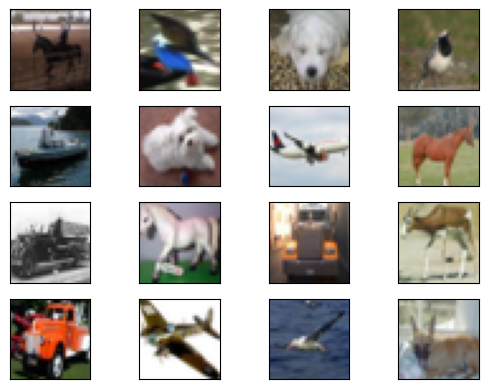

In [308]:
real_samples, cifar_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    image = real_samples[i].cpu().detach().numpy()
    image = (image + 1) / 2.0
    plt.imshow(image.transpose(1, 2, 0))    
    plt.xticks([])
    plt.yticks([])

In [309]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(3 * 32 * 32, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        output = self.model(x)
        return output

In [310]:
discriminator = Discriminator().to(device=device)

In [311]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 3 * 32 * 32),  # Output 3 channels
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 3, 32, 32)  # Reshape to (batch_size, 3, 32, 32)
        return output

generator = Generator().to(device=device)

In [312]:
lr = 0.0001
num_epochs = 150
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

## Train

In [313]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)

        # Ensure all_samples_labels has the correct size
        all_samples_labels = all_samples_labels[:output_discriminator.size(0), :]

        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )

        # Training the generator
        generator.zero_grad()
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)
        generated_samples = generator(latent_space_samples)

        # Ensure the generated samples have three channels (RGB) and flatten
        generated_samples = generated_samples.view(batch_size, -1)

        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()
        # Show loss
        if (n + 1) % 100 == 0:
            print(f"Epoch: {epoch}/{num_epochs} | Step: {n + 1}/{len(train_loader)}\n     Loss D.: {loss_discriminator}\n     Loss G.: {loss_generator}")

Epoch: 0/150 | Step: 100/1563
     Loss D.: 0.31171074509620667
     Loss G.: 0.8176841139793396
Epoch: 0/150 | Step: 200/1563
     Loss D.: 0.0995386391878128
     Loss G.: 1.8759379386901855
Epoch: 0/150 | Step: 300/1563
     Loss D.: 0.01563999056816101
     Loss G.: 4.545191764831543
Epoch: 0/150 | Step: 400/1563
     Loss D.: 0.08147953450679779
     Loss G.: 2.7033913135528564
Epoch: 0/150 | Step: 500/1563
     Loss D.: 0.18223093450069427
     Loss G.: 2.7083568572998047
Epoch: 0/150 | Step: 600/1563
     Loss D.: 0.01666579209268093
     Loss G.: 5.178462028503418
Epoch: 0/150 | Step: 700/1563
     Loss D.: 0.013670876622200012
     Loss G.: 5.824906826019287
Epoch: 0/150 | Step: 800/1563
     Loss D.: 0.013414734043180943
     Loss G.: 6.968888282775879
Epoch: 0/150 | Step: 900/1563
     Loss D.: 0.020327122882008553
     Loss G.: 4.868551254272461
Epoch: 0/150 | Step: 1000/1563
     Loss D.: 0.13244757056236267
     Loss G.: 7.318399906158447
Epoch: 0/150 | Step: 1100/1563
  

In [314]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

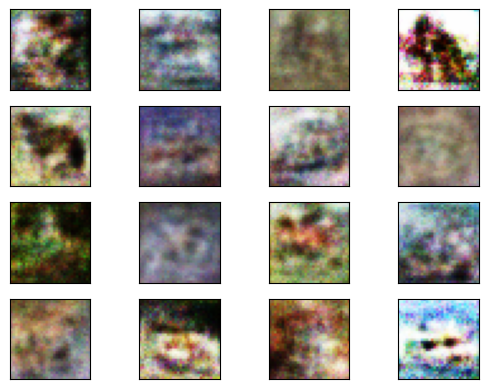

In [315]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    
    # Assuming the generated samples have shape (batch_size, 3, 32, 32)
    generated_image = generated_samples[i].cpu().detach().numpy().transpose((1, 2, 0))
    
    # Rescale the pixel values to the range [0, 1] for proper display
    generated_image = 0.5 * generated_image + 0.5
    
    plt.imshow(generated_image)
    plt.xticks([])
    plt.yticks([])

plt.show()